In [15]:
import sys
import os


project_root = "C:/Users/Visnu/DIAMONDS"  


if project_root not in sys.path:
    sys.path.append(project_root)


from diamonds import set_data_path, load_patients
import diamonds.data as dt


In [16]:
from diamonds import set_data_path, load_patients
import diamonds.data as dt
import os


data_path = "C:/Users/Visnu/OneDrive - Danmarks Tekniske Universitet/DIAMONDS - Preclinical_new"


set_data_path(data_path)

print("Dataset Path:", data_path)
print("Contents:", os.listdir(data_path)) 



Dataset Path: C:/Users/Visnu/OneDrive - Danmarks Tekniske Universitet/DIAMONDS - Preclinical_new
Contents: ['desktop.ini', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16']


In [17]:
import diamonds.data as dt
import pandas as pd
import diamonds.io.io as dio

def filtered_patient_list():
    return [
        item for item in os.listdir(data_path)
        if os.path.isdir(os.path.join(data_path, item)) and not item.lower().endswith(".ini")
    ]


dio.get_patient_list = filtered_patient_list

ptt = load_patients(show_progress=True)
pt = ptt[5]




Loading patients: 100%|██████████| 15/15 [00:00<00:00, 49.28patient(s)/s]


In [ ]:


import argparse
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, cross_val_predict, cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ──────────────────────────────────────────────────────────────────────────────
# 1. Config
# ──────────────────────────────────────────────────────────────────────────────
NUMERIC_COLS = [
    "EDR_BPM",
    "n_breaths",
    "AvgTotalBreathDuration",
    "TrueInspDuration",
    "TrueExpDuration",
    "IEratio",
]
CATEGORICAL_COLS = ["session_type", "exercise"]

TARGET_COLS = [
    "gold_BPM",
    "gold_TrueInspDuration",
    "gold_TrueExpDuration",
    "gold_AvgTotalBreathDuration",
    "gold_IEratio",
    "gold_n_breaths",
]



def load_dataset(path: str | Path) -> pd.DataFrame:
    df = pd.read_excel(path)
    # Remove “Hold” rows
    return df[~df["exercise"].str.lower().eq("hold")].reset_index(drop=True)


def train_test_split_fixed(df: pd.DataFrame, train_path: str, test_path: str):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(df, groups=df["subject_id"]))

    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)

    df_train.to_excel(train_path, index=False)
    df_test.to_excel(test_path, index=False)

    print(f"✅ Saved fixed Train/Test splits: {df_train.shape[0]} train rows, {df_test.shape[0]} test rows.")
    return df_train, df_test



import os

def build_pipeline() -> Pipeline:

    optuna_study_path = "optuna_breath_study_10.pkl"
    if os.path.exists(optuna_study_path):
        print("🔍 Found Optuna study – loading best parameters...")
        study = joblib.load(optuna_study_path)
        best_params = study.best_params
        n_estimators = best_params.get("n_estimators", 400)
        max_depth = best_params.get("max_depth", None)
        min_samples_leaf = best_params.get("min_samples_leaf", 1)
    else:
        print("No Optuna study found – using default parameters...")
        n_estimators = 400
        max_depth = None
        min_samples_leaf = 1

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), NUMERIC_COLS),
            ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COLS),
        ],
        remainder="drop",
    )

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=0,
        n_jobs=-1,
    )

    pipe = Pipeline(
        steps=[
            ("prep", preprocessor),
            ("reg", MultiOutputRegressor(rf, n_jobs=-1)),
        ]
    )
    return pipe 



def main(data_path: str, model_out: str):
    df = load_dataset(data_path)


    df_train, df_test = train_test_split_fixed(df, "train_split_10.xlsx", "test_split_10.xlsx")
    np.savez("breath_segmentation_split_indices_10.npz", 
         train_subjects=df_train["subject_id"].unique(), 
         test_subjects=df_test["subject_id"].unique())
    


    X_train = df_train[NUMERIC_COLS + CATEGORICAL_COLS]
    y_train = df_train[TARGET_COLS]
    groups_train = df_train["subject_id"]

    X_test = df_test[NUMERIC_COLS + CATEGORICAL_COLS]
    y_test = df_test[TARGET_COLS]

    pipe = build_pipeline()
    gkf = GroupKFold(n_splits=5)


    print("\n🔵 Cross-validating on TRAIN set...")
    cv_predictions = cross_val_predict(
        pipe,
        X_train,
        y_train,
        cv=gkf,
        groups=groups_train,
        n_jobs=-1,
    )

    cv_results = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=gkf,
        groups=groups_train,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        return_train_score=False,
    )
    print("\nFold-wise CV MAE (seconds or BPM):", -cv_results["test_score"])
    print("Mean CV MAE:", (-cv_results["test_score"]).mean().round(3))


    print("\n⚡ Fitting final model on full TRAIN set...")
    pipe.fit(X_train, y_train)

    version = 1
    base_model_name = model_out.replace(".joblib", "")
    model_filename = f"{base_model_name}_v{version}.joblib"

    while os.path.exists(model_filename):
        version += 1
        model_filename = f"{base_model_name}_v{version}.joblib"

    joblib.dump(pipe, model_filename)
    print(f"\n✅ Model saved to: {model_filename}")



    print("Evaluating on TEST set...")
    test_preds = pipe.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_preds, multioutput='raw_values')
    print("\nTest set MAE (seconds or BPM):", test_mae)
    print("Mean Test MAE:", np.mean(test_mae).round(3)) 



if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train breath ML model with fixed train/test split.")
    parser.add_argument("--data_path", type=str, default="C:/Users/visnu/DIAMONDS/Thesis code/Datafiles/breath_merics_dataset_QRS_with_exercise_hold_both.xlsx")
    parser.add_argument("--model_out", type=str, default="breath_ml_model_10.joblib")

    args, unknown = parser.parse_known_args()  

    main(args.data_path, args.model_out)



✅ Saved fixed Train/Test splits: 1799 train rows, 462 test rows.
🔍 Found Optuna study – loading best parameters...

🔵 Cross-validating on TRAIN set...

Fold-wise CV MAE (seconds or BPM): [1.31973354 1.15702535 0.95897917 0.98438607 1.43380288]
Mean CV MAE: 1.171

⚡ Fitting final model on full TRAIN set...

✅ Model saved to: breath_ml_model_10_v1.joblib

🟠 Evaluating on TEST set...

Test set MAE (seconds or BPM): [4.54266624 0.71815541 0.52994288 0.90264052 0.44177369 0.79638754]
Mean Test MAE: 1.322


In [ ]:
import optuna
import pandas as pd
import joblib
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


NUMERIC_COLS = [
    "EDR_BPM",
    "n_breaths",
    "AvgTotalBreathDuration",
    "TrueInspDuration",
    "TrueExpDuration",
    "IEratio",
]
CATEGORICAL_COLS = []

TARGET_COLS = [
    "gold_BPM",
    "gold_TrueInspDuration",
    "gold_TrueExpDuration",
    "gold_AvgTotalBreathDuration",
    "gold_IEratio",
    "gold_n_breaths",
]



train_df = pd.read_excel("C:/Users/visnu/DIAMONDS/Thesis code/Breath_Segmentation/Phase 2/train_split_10.xlsx")

X_train = train_df[NUMERIC_COLS + CATEGORICAL_COLS]
y_train = train_df[TARGET_COLS]
groups_train = train_df["subject_id"]


def build_pipeline(n_estimators=400, max_depth=None, min_samples_leaf=1) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), NUMERIC_COLS),
            ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COLS),
        ],
        remainder="drop",
    )

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=0,
        n_jobs=-1,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
    )

    pipe = Pipeline(
        steps=[
            ("prep", preprocessor),
            ("reg", MultiOutputRegressor(rf, n_jobs=-1)),
        ]
    )
    return pipe



def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 800)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    pipe = build_pipeline(n_estimators, max_depth, min_samples_leaf)

    gkf = GroupKFold(n_splits=5)


    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv=gkf,
        groups=groups_train,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )

    mean_score = np.mean(scores)

    return -mean_score  # minimize positive MAE



study = optuna.create_study(direction="minimize", study_name="breath_rf_optuna")
study.optimize(objective, n_trials=30, show_progress_bar=True)
import optuna.visualization as vis


vis.plot_optimization_history(study)



best_params = study.best_params
print("\n✅ Best hyperparameters found:", best_params)
print("Best Mean CV MAE:", study.best_value)


joblib.dump(study, "optuna_breath_study_10.pkl")


[I 2025-05-12 18:26:07,501] A new study created in memory with name: breath_rf_optuna
Best trial: 0. Best value: 1.17385:   3%|▎         | 1/30 [00:07<03:39,  7.56s/it]

[I 2025-05-12 18:26:15,059] Trial 0 finished with value: 1.173848707257663 and parameters: {'n_estimators': 569, 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 0 with value: 1.173848707257663.


Best trial: 0. Best value: 1.17385:   7%|▋         | 2/30 [00:11<02:24,  5.17s/it]

[I 2025-05-12 18:26:18,549] Trial 1 finished with value: 1.1826286355478843 and parameters: {'n_estimators': 217, 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 1.173848707257663.


Best trial: 0. Best value: 1.17385:  10%|█         | 3/30 [00:16<02:16,  5.07s/it]

[I 2025-05-12 18:26:23,502] Trial 2 finished with value: 1.1807729330056884 and parameters: {'n_estimators': 327, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 0 with value: 1.173848707257663.


Best trial: 3. Best value: 1.17182:  13%|█▎        | 4/30 [00:21<02:11,  5.06s/it]

[I 2025-05-12 18:26:28,538] Trial 3 finished with value: 1.1718166262264271 and parameters: {'n_estimators': 383, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  17%|█▋        | 5/30 [00:23<01:40,  4.02s/it]

[I 2025-05-12 18:26:30,724] Trial 4 finished with value: 1.1768505621982157 and parameters: {'n_estimators': 188, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  20%|██        | 6/30 [00:29<01:52,  4.69s/it]

[I 2025-05-12 18:26:36,707] Trial 5 finished with value: 1.1807229870719527 and parameters: {'n_estimators': 524, 'max_depth': 45, 'min_samples_leaf': 5}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  23%|██▎       | 7/30 [00:31<01:32,  4.03s/it]

[I 2025-05-12 18:26:39,380] Trial 6 finished with value: 1.1768214904908512 and parameters: {'n_estimators': 228, 'max_depth': 40, 'min_samples_leaf': 6}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  27%|██▋       | 8/30 [00:38<01:45,  4.78s/it]

[I 2025-05-12 18:26:45,758] Trial 7 finished with value: 1.1766594557008552 and parameters: {'n_estimators': 521, 'max_depth': 36, 'min_samples_leaf': 6}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  30%|███       | 9/30 [00:44<01:49,  5.20s/it]

[I 2025-05-12 18:26:51,884] Trial 8 finished with value: 1.1942501076764638 and parameters: {'n_estimators': 522, 'max_depth': 9, 'min_samples_leaf': 1}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  33%|███▎      | 10/30 [00:50<01:49,  5.49s/it]

[I 2025-05-12 18:26:58,029] Trial 9 finished with value: 1.2050334356023746 and parameters: {'n_estimators': 401, 'max_depth': 46, 'min_samples_leaf': 2}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  37%|███▋      | 11/30 [00:57<01:50,  5.81s/it]

[I 2025-05-12 18:27:04,568] Trial 10 finished with value: 1.1720505087471496 and parameters: {'n_estimators': 637, 'max_depth': 22, 'min_samples_leaf': 10}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  40%|████      | 12/30 [01:05<01:56,  6.47s/it]

[I 2025-05-12 18:27:12,537] Trial 11 finished with value: 1.1723827770371096 and parameters: {'n_estimators': 782, 'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  43%|████▎     | 13/30 [01:11<01:51,  6.58s/it]

[I 2025-05-12 18:27:19,388] Trial 12 finished with value: 1.1720443603396364 and parameters: {'n_estimators': 684, 'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 3. Best value: 1.17182:  47%|████▋     | 14/30 [01:18<01:43,  6.48s/it]

[I 2025-05-12 18:27:25,620] Trial 13 finished with value: 1.1984458432637637 and parameters: {'n_estimators': 759, 'max_depth': 5, 'min_samples_leaf': 8}. Best is trial 3 with value: 1.1718166262264271.


Best trial: 14. Best value: 1.17158:  50%|█████     | 15/30 [01:21<01:24,  5.65s/it]

[I 2025-05-12 18:27:29,366] Trial 14 finished with value: 1.1715846882935623 and parameters: {'n_estimators': 362, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 14 with value: 1.1715846882935623.


Best trial: 14. Best value: 1.17158:  53%|█████▎    | 16/30 [01:25<01:11,  5.09s/it]

[I 2025-05-12 18:27:33,152] Trial 15 finished with value: 1.1722168863983842 and parameters: {'n_estimators': 360, 'max_depth': 14, 'min_samples_leaf': 8}. Best is trial 14 with value: 1.1715846882935623.


Best trial: 14. Best value: 1.17158:  57%|█████▋    | 17/30 [01:28<00:58,  4.48s/it]

[I 2025-05-12 18:27:36,217] Trial 16 finished with value: 1.1719277369495444 and parameters: {'n_estimators': 287, 'max_depth': 33, 'min_samples_leaf': 8}. Best is trial 14 with value: 1.1715846882935623.


Best trial: 14. Best value: 1.17158:  60%|██████    | 18/30 [01:29<00:41,  3.48s/it]

[I 2025-05-12 18:27:37,353] Trial 17 finished with value: 1.173833276878306 and parameters: {'n_estimators': 104, 'max_depth': 14, 'min_samples_leaf': 9}. Best is trial 14 with value: 1.1715846882935623.


Best trial: 18. Best value: 1.1714:  63%|██████▎   | 19/30 [01:34<00:41,  3.76s/it] 

[I 2025-05-12 18:27:41,778] Trial 18 finished with value: 1.1713967282728182 and parameters: {'n_estimators': 435, 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 18 with value: 1.1713967282728182.


Best trial: 18. Best value: 1.1714:  67%|██████▋   | 20/30 [01:39<00:41,  4.12s/it]

[I 2025-05-12 18:27:46,717] Trial 19 finished with value: 1.1716664093823959 and parameters: {'n_estimators': 481, 'max_depth': 28, 'min_samples_leaf': 9}. Best is trial 18 with value: 1.1713967282728182.


Best trial: 18. Best value: 1.1714:  70%|███████   | 21/30 [01:45<00:41,  4.64s/it]

[I 2025-05-12 18:27:52,583] Trial 20 finished with value: 1.1942468738442615 and parameters: {'n_estimators': 455, 'max_depth': 31, 'min_samples_leaf': 3}. Best is trial 18 with value: 1.1713967282728182.


Best trial: 18. Best value: 1.1714:  73%|███████▎  | 22/30 [01:49<00:36,  4.59s/it]

[I 2025-05-12 18:27:57,061] Trial 21 finished with value: 1.1714948352910861 and parameters: {'n_estimators': 437, 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 18 with value: 1.1713967282728182.


Best trial: 18. Best value: 1.1714:  77%|███████▋  | 23/30 [01:53<00:31,  4.48s/it]

[I 2025-05-12 18:28:01,291] Trial 22 finished with value: 1.1714427102937832 and parameters: {'n_estimators': 413, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 18 with value: 1.1713967282728182.


Best trial: 18. Best value: 1.1714:  80%|████████  | 24/30 [01:58<00:27,  4.60s/it]

[I 2025-05-12 18:28:06,162] Trial 23 finished with value: 1.1747288257004558 and parameters: {'n_estimators': 436, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 18 with value: 1.1713967282728182.


Best trial: 18. Best value: 1.1714:  83%|████████▎ | 25/30 [02:04<00:25,  5.08s/it]

[I 2025-05-12 18:28:12,346] Trial 24 finished with value: 1.1724170751412293 and parameters: {'n_estimators': 613, 'max_depth': 37, 'min_samples_leaf': 9}. Best is trial 18 with value: 1.1713967282728182.


Best trial: 18. Best value: 1.1714:  87%|████████▋ | 26/30 [02:07<00:17,  4.45s/it]

[I 2025-05-12 18:28:15,325] Trial 25 finished with value: 1.1746338002111818 and parameters: {'n_estimators': 279, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 18 with value: 1.1713967282728182.


Best trial: 26. Best value: 1.1711:  90%|█████████ | 27/30 [02:12<00:13,  4.43s/it]

[I 2025-05-12 18:28:19,728] Trial 26 finished with value: 1.1711036201697644 and parameters: {'n_estimators': 433, 'max_depth': 32, 'min_samples_leaf': 10}. Best is trial 26 with value: 1.1711036201697644.


Best trial: 26. Best value: 1.1711:  93%|█████████▎| 28/30 [02:17<00:09,  4.58s/it]

[I 2025-05-12 18:28:24,659] Trial 27 finished with value: 1.1715530333358881 and parameters: {'n_estimators': 488, 'max_depth': 32, 'min_samples_leaf': 10}. Best is trial 26 with value: 1.1711036201697644.


Best trial: 28. Best value: 1.17079:  97%|█████████▋| 29/30 [02:20<00:04,  4.15s/it]

[I 2025-05-12 18:28:27,806] Trial 28 finished with value: 1.1707854017038346 and parameters: {'n_estimators': 314, 'max_depth': 39, 'min_samples_leaf': 10}. Best is trial 28 with value: 1.1707854017038346.


Best trial: 28. Best value: 1.17079: 100%|██████████| 30/30 [02:23<00:00,  4.78s/it]

[I 2025-05-12 18:28:30,857] Trial 29 finished with value: 1.1708917944034187 and parameters: {'n_estimators': 307, 'max_depth': 43, 'min_samples_leaf': 10}. Best is trial 28 with value: 1.1707854017038346.

✅ Best hyperparameters found: {'n_estimators': 314, 'max_depth': 39, 'min_samples_leaf': 10}
Best Mean CV MAE: 1.1707854017038346


['optuna_breath_study_10.pkl']

In [ ]:
import os
import argparse
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit


DATAFILES_FOLDER = r"C:/Users/visnu/DIAMONDS/Thesis code\Datafiles"
os.makedirs(DATAFILES_FOLDER, exist_ok=True)  


def load_dataset(path: str | Path) -> pd.DataFrame:
    df = pd.read_excel(path)
    return df[~df["exercise"].str.lower().eq("hold")].reset_index(drop=True)

def train_test_split_fixed(df: pd.DataFrame):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(df, groups=df["subject_id"]))

    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)


    train_path = os.path.join(DATAFILES_FOLDER, "train_split_10.xlsx")
    test_path = os.path.join(DATAFILES_FOLDER, "test_split_10.xlsx")

    df_train.to_excel(train_path, index=False)
    df_test.to_excel(test_path, index=False)

    print(f"✅ Saved fixed Train/Test splits: {df_train.shape[0]} train rows, {df_test.shape[0]} test rows.")
    return df_train, df_test


def main(data_path: str, model_out: str):
    df = load_dataset(data_path)


    df_train, df_test = train_test_split_fixed(df)


    npz_path = os.path.join(DATAFILES_FOLDER, "breath_segmentation_split_indices_10.npz")
    np.savez(npz_path, 
             train_subjects=df_train["subject_id"].unique(), 
             test_subjects=df_test["subject_id"].unique())

    print(f"✅ Saved indices file: {npz_path}")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Train breath ML model with fixed train/test split.")
    parser.add_argument("--data_path", type=str, default="C:/Users/visnu/DIAMONDS/Thesis code/Datafiles/breath_merics_dataset_QRS_with_exercise_hold_both.xlsx")
    parser.add_argument("--model_out", type=str, default=os.path.join(DATAFILES_FOLDER, "breath_ml_model_10.joblib"))  # Ensure model is stored in Datafiles

    args, unknown = parser.parse_known_args()  

    main(args.data_path, args.model_out)


✅ Saved fixed Train/Test splits: 1799 train rows, 462 test rows.
✅ Saved indices file: C:/Users/visnu/DIAMONDS/Thesis code\Datafiles\breath_segmentation_split_indices_10.npz


In [ ]:
import os
import optuna
import pandas as pd
import joblib
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


DATAFILES_FOLDER = r"C:/Users/visnu/DIAMONDS/Thesis code\Datafiles"
os.makedirs(DATAFILES_FOLDER, exist_ok=True)  


train_path = os.path.join(DATAFILES_FOLDER, "train_split_10.xlsx")
train_df = pd.read_excel(train_path)

X_train = train_df[[
    "EDR_BPM", "n_breaths", "AvgTotalBreathDuration",
    "TrueInspDuration", "TrueExpDuration", "IEratio",
    "session_type", "exercise"
]]
y_train = train_df[[
    "gold_BPM", "gold_TrueInspDuration", "gold_TrueExpDuration",
    "gold_AvgTotalBreathDuration", "gold_IEratio", "gold_n_breaths"
]]
groups_train = train_df["subject_id"]


def build_pipeline(n_estimators=400, max_depth=None, min_samples_leaf=1) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), X_train.columns[:-2]),  # Numeric cols
            ("cat", OneHotEncoder(handle_unknown="ignore"), X_train.columns[-2:]),  # Categorical cols
        ],
        remainder="drop",
    )

    rf = RandomForestRegressor(
        n_estimators=n_estimators, random_state=0, n_jobs=-1,
        max_depth=max_depth, min_samples_leaf=min_samples_leaf,
    )

    pipe = Pipeline(steps=[("prep", preprocessor), ("reg", MultiOutputRegressor(rf, n_jobs=-1))])
    return pipe


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 800)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    pipe = build_pipeline(n_estimators, max_depth, min_samples_leaf)
    gkf = GroupKFold(n_splits=5)

    # Score is negative MAE; we want to minimize MAE
    scores = cross_val_score(pipe, X_train, y_train, cv=gkf, groups=groups_train, scoring="neg_mean_absolute_error", n_jobs=-1)
    return -np.mean(scores)  # minimize positive MAE


study = optuna.create_study(direction="minimize", study_name="breath_rf_optuna")
study.optimize(objective, n_trials=30, show_progress_bar=True)

import optuna.visualization as vis
vis.plot_optimization_history(study)


best_params = study.best_params
print("\n✅ Best hyperparameters found:", best_params)
print("Best Mean CV MAE:", study.best_value)


study_path = os.path.join(DATAFILES_FOLDER, "optuna_breath_study_10.pkl")
joblib.dump(study, study_path)

print(f"✅ Saved Optuna study to '{study_path}'")


[I 2025-05-12 18:16:10,751] A new study created in memory with name: breath_rf_optuna
Best trial: 0. Best value: 1.20465:   3%|▎         | 1/30 [00:08<03:52,  8.03s/it]

[I 2025-05-12 18:16:18,776] Trial 0 finished with value: 1.2046450624833807 and parameters: {'n_estimators': 309, 'max_depth': 48, 'min_samples_leaf': 2}. Best is trial 0 with value: 1.2046450624833807.


Best trial: 0. Best value: 1.20465:   7%|▋         | 2/30 [00:12<02:54,  6.22s/it]

[I 2025-05-12 18:16:23,736] Trial 1 finished with value: 1.2054673914445009 and parameters: {'n_estimators': 311, 'max_depth': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 1.2046450624833807.


Best trial: 2. Best value: 1.18565:  10%|█         | 3/30 [00:20<02:58,  6.63s/it]

[I 2025-05-12 18:16:30,844] Trial 2 finished with value: 1.1856532030977696 and parameters: {'n_estimators': 461, 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.1856532030977696.


Best trial: 2. Best value: 1.18565:  13%|█▎        | 4/30 [00:29<03:19,  7.66s/it]

[I 2025-05-12 18:16:40,098] Trial 3 finished with value: 1.1936432995467414 and parameters: {'n_estimators': 720, 'max_depth': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 1.1856532030977696.


Best trial: 4. Best value: 1.17192:  17%|█▋        | 5/30 [00:35<02:57,  7.10s/it]

[I 2025-05-12 18:16:46,198] Trial 4 finished with value: 1.1719248299955172 and parameters: {'n_estimators': 503, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 4 with value: 1.1719248299955172.


Best trial: 4. Best value: 1.17192:  20%|██        | 6/30 [00:36<02:02,  5.11s/it]

[I 2025-05-12 18:16:47,435] Trial 5 finished with value: 1.1788033453115363 and parameters: {'n_estimators': 103, 'max_depth': 8, 'min_samples_leaf': 6}. Best is trial 4 with value: 1.1719248299955172.


Best trial: 6. Best value: 1.1718:  23%|██▎       | 7/30 [00:42<02:04,  5.43s/it] 

[I 2025-05-12 18:16:53,546] Trial 6 finished with value: 1.1717984233908023 and parameters: {'n_estimators': 500, 'max_depth': 28, 'min_samples_leaf': 9}. Best is trial 6 with value: 1.1717984233908023.


Best trial: 6. Best value: 1.1718:  27%|██▋       | 8/30 [00:51<02:23,  6.53s/it]

[I 2025-05-12 18:17:02,406] Trial 7 finished with value: 1.203030283478752 and parameters: {'n_estimators': 561, 'max_depth': 12, 'min_samples_leaf': 1}. Best is trial 6 with value: 1.1717984233908023.


Best trial: 6. Best value: 1.1718:  30%|███       | 9/30 [01:02<02:43,  7.78s/it]

[I 2025-05-12 18:17:12,940] Trial 8 finished with value: 1.1800165258900266 and parameters: {'n_estimators': 762, 'max_depth': 15, 'min_samples_leaf': 5}. Best is trial 6 with value: 1.1717984233908023.


Best trial: 6. Best value: 1.1718:  33%|███▎      | 10/30 [01:13<02:54,  8.74s/it]

[I 2025-05-12 18:17:23,839] Trial 9 finished with value: 1.1861909491943277 and parameters: {'n_estimators': 747, 'max_depth': 38, 'min_samples_leaf': 4}. Best is trial 6 with value: 1.1717984233908023.


Best trial: 10. Best value: 1.17067:  37%|███▋      | 11/30 [01:17<02:19,  7.34s/it]

[I 2025-05-12 18:17:28,003] Trial 10 finished with value: 1.170665343768986 and parameters: {'n_estimators': 340, 'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  40%|████      | 12/30 [01:21<01:53,  6.28s/it]

[I 2025-05-12 18:17:31,867] Trial 11 finished with value: 1.1709325703871216 and parameters: {'n_estimators': 317, 'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  43%|████▎     | 13/30 [01:24<01:32,  5.47s/it]

[I 2025-05-12 18:17:35,454] Trial 12 finished with value: 1.1710949013801715 and parameters: {'n_estimators': 287, 'max_depth': 23, 'min_samples_leaf': 10}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  47%|████▋     | 14/30 [01:27<01:13,  4.59s/it]

[I 2025-05-12 18:17:38,013] Trial 13 finished with value: 1.1734109791792409 and parameters: {'n_estimators': 195, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  50%|█████     | 15/30 [01:31<01:09,  4.60s/it]

[I 2025-05-12 18:17:42,653] Trial 14 finished with value: 1.1710873994950282 and parameters: {'n_estimators': 376, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  53%|█████▎    | 16/30 [01:34<00:56,  4.06s/it]

[I 2025-05-12 18:17:45,443] Trial 15 finished with value: 1.171539923456017 and parameters: {'n_estimators': 214, 'max_depth': 34, 'min_samples_leaf': 8}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  57%|█████▋    | 17/30 [01:42<01:07,  5.16s/it]

[I 2025-05-12 18:17:53,169] Trial 16 finished with value: 1.1721372436362798 and parameters: {'n_estimators': 630, 'max_depth': 35, 'min_samples_leaf': 9}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  60%|██████    | 18/30 [01:47<01:00,  5.02s/it]

[I 2025-05-12 18:17:57,873] Trial 17 finished with value: 1.171010800308739 and parameters: {'n_estimators': 385, 'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  63%|██████▎   | 19/30 [01:52<00:56,  5.12s/it]

[I 2025-05-12 18:18:03,202] Trial 18 finished with value: 1.1749400023219418 and parameters: {'n_estimators': 408, 'max_depth': 42, 'min_samples_leaf': 7}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  67%|██████▋   | 20/30 [01:55<00:44,  4.49s/it]

[I 2025-05-12 18:18:06,224] Trial 19 finished with value: 1.1708195911480817 and parameters: {'n_estimators': 238, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  70%|███████   | 21/30 [01:57<00:32,  3.64s/it]

[I 2025-05-12 18:18:07,877] Trial 20 finished with value: 1.1714623154749415 and parameters: {'n_estimators': 126, 'max_depth': 15, 'min_samples_leaf': 8}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  73%|███████▎  | 22/30 [02:00<00:27,  3.44s/it]

[I 2025-05-12 18:18:10,874] Trial 21 finished with value: 1.1708837492746464 and parameters: {'n_estimators': 235, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  77%|███████▋  | 23/30 [02:02<00:22,  3.25s/it]

[I 2025-05-12 18:18:13,658] Trial 22 finished with value: 1.1709497069741877 and parameters: {'n_estimators': 218, 'max_depth': 24, 'min_samples_leaf': 9}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  80%|████████  | 24/30 [02:06<00:19,  3.27s/it]

[I 2025-05-12 18:18:16,982] Trial 23 finished with value: 1.1745289902956308 and parameters: {'n_estimators': 255, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  83%|████████▎ | 25/30 [02:08<00:14,  2.91s/it]

[I 2025-05-12 18:18:19,047] Trial 24 finished with value: 1.1711135847389575 and parameters: {'n_estimators': 161, 'max_depth': 31, 'min_samples_leaf': 9}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  87%|████████▋ | 26/30 [02:13<00:13,  3.48s/it]

[I 2025-05-12 18:18:23,853] Trial 25 finished with value: 1.177372486539453 and parameters: {'n_estimators': 357, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  90%|█████████ | 27/30 [02:16<00:10,  3.41s/it]

[I 2025-05-12 18:18:27,105] Trial 26 finished with value: 1.1720222120744161 and parameters: {'n_estimators': 255, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  93%|█████████▎| 28/30 [02:18<00:06,  3.03s/it]

[I 2025-05-12 18:18:29,236] Trial 27 finished with value: 1.1709131750498358 and parameters: {'n_estimators': 160, 'max_depth': 31, 'min_samples_leaf': 9}. Best is trial 10 with value: 1.170665343768986.


Best trial: 10. Best value: 1.17067:  97%|█████████▋| 29/30 [02:21<00:03,  3.02s/it]

[I 2025-05-12 18:18:32,239] Trial 28 finished with value: 1.1707214924152658 and parameters: {'n_estimators': 239, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 10 with value: 1.170665343768986.


Best trial: 29. Best value: 1.17054: 100%|██████████| 30/30 [02:25<00:00,  4.85s/it]

[I 2025-05-12 18:18:36,311] Trial 29 finished with value: 1.1705359506879187 and parameters: {'n_estimators': 333, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 29 with value: 1.1705359506879187.

✅ Best hyperparameters found: {'n_estimators': 333, 'max_depth': 13, 'min_samples_leaf': 10}
Best Mean CV MAE: 1.1705359506879187
✅ Saved Optuna study to 'C:/Users/visnu/DIAMONDS/Thesis code\Datafiles\optuna_breath_study_10.pkl'


In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


DATAFILES_FOLDER   = r"C:/Users/visnu/DIAMONDS/Thesis code/Datafiles"
TRAIN_PATH         = os.path.join(DATAFILES_FOLDER, "train_split_10.xlsx")
TEST_PATH          = os.path.join(DATAFILES_FOLDER, "test_split_10.xlsx")
NPZ_PATH           = os.path.join(DATAFILES_FOLDER, "breath_segmentation_split_indices_10.npz")
OPTUNA_STUDY_PATH  = os.path.join(DATAFILES_FOLDER, "optuna_breath_study_10.pkl")

NUMERIC_COLS       = [
    "EDR_BPM",
    "n_breaths",
    "AvgTotalBreathDuration",
    "TrueInspDuration",
    "TrueExpDuration",
    "IEratio",
]
CATEGORICAL_COLS   = []   

TARGET_COLS        = [
    "gold_BPM",
    "gold_TrueInspDuration",
    "gold_TrueExpDuration",
    "gold_AvgTotalBreathDuration",
    "gold_IEratio",
    "gold_n_breaths",
]


def build_pipeline() -> Pipeline:
    if os.path.exists(OPTUNA_STUDY_PATH):
        study      = joblib.load(OPTUNA_STUDY_PATH)
        best_params = study.best_params
    else:
        best_params = {"n_estimators": 400, "max_depth": None, "min_samples_leaf": 1}

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COLS),
    ])

    rf = RandomForestRegressor(**best_params, random_state=0, n_jobs=-1)
    return Pipeline([("prep", preprocessor),
                     ("reg",  MultiOutputRegressor(rf, n_jobs=-1))])

def main(model_out: str):

    df_train = pd.read_excel(TRAIN_PATH)
    df_test  = pd.read_excel(TEST_PATH)


    splits = np.load(NPZ_PATH, allow_pickle=True)
    assert set(df_train.subject_id.unique()) == set(splits["train_subjects"])
    assert set(df_test .subject_id.unique()) == set(splits["test_subjects"])


    X_train, y_train = df_train[NUMERIC_COLS + CATEGORICAL_COLS], df_train[TARGET_COLS]
    X_test,  y_test  = df_test [NUMERIC_COLS + CATEGORICAL_COLS], df_test [TARGET_COLS]
    groups_train     = df_train["subject_id"]


    pipe = build_pipeline()
    gkf  = GroupKFold(n_splits=5)

    print("\n🔵 Cross-validating on TRAIN set...")
    cv_results = cross_validate(
        pipe, X_train, y_train,
        cv=gkf, groups=groups_train,
        scoring="neg_mean_absolute_error", n_jobs=-1
    )
    print("Mean CV MAE:", (-cv_results["test_score"]).mean().round(3))


    print("Fitting final model on full TRAIN set...")
    pipe.fit(X_train, y_train)
    model_path = os.path.join(DATAFILES_FOLDER, model_out)
    joblib.dump(pipe, model_path)
    print(f"✅ Model saved to '{model_path}'")


    print("Evaluating on TEST set...")
    test_preds = pipe.predict(X_test)
    test_mae   = mean_absolute_error(y_test, test_preds, multioutput="raw_values")
    print("Mean Test MAE:", np.mean(test_mae).round(3))


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_out", type=str, default="breath_ml_model_10.joblib")
    args, _ = parser.parse_known_args()   




🔵 Cross-validating on TRAIN set...
Mean CV MAE: 1.171

⚡ Fitting final model on full TRAIN set...
✅ Model saved to 'C:/Users/visnu/DIAMONDS/Thesis code/Datafiles\breath_ml_model_10.joblib'

🟠 Evaluating on TEST set...
Mean Test MAE: 1.322


📊 MAE per feature (Baseline vs Gold): [4.56  1.475 2.009 2.386 0.892 0.942]
📊 MAE per feature (Predicted vs Gold): [4.542 0.716 0.53  0.902 0.442 0.796]

📉 Mean Baseline MAE:  2.044
📈 Mean Predicted MAE: 1.321
📉 Mean Baseline R²:   -2.177
📈 Mean Predicted R²:  0.156


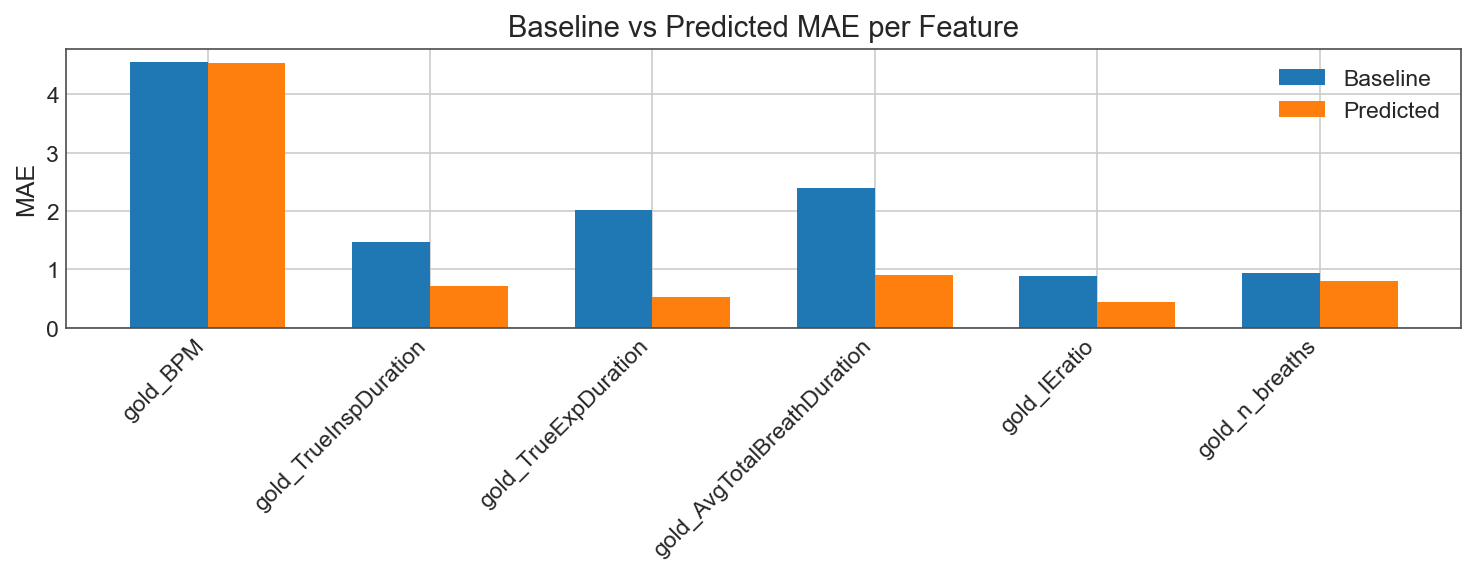

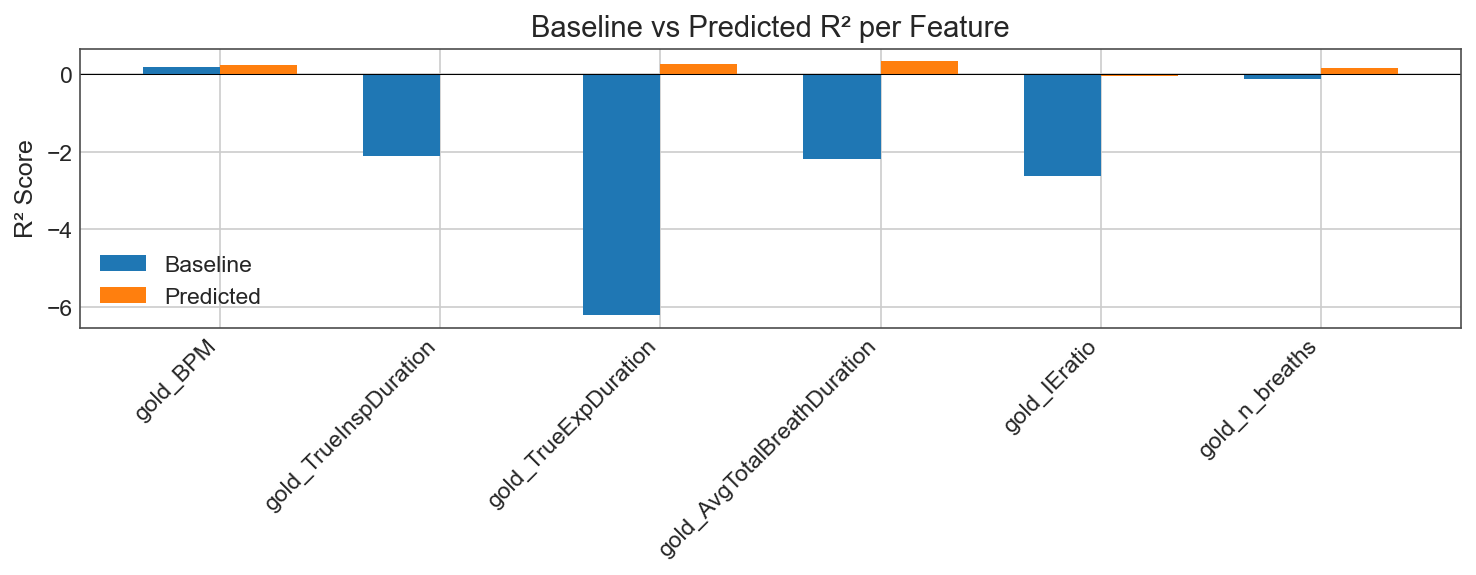

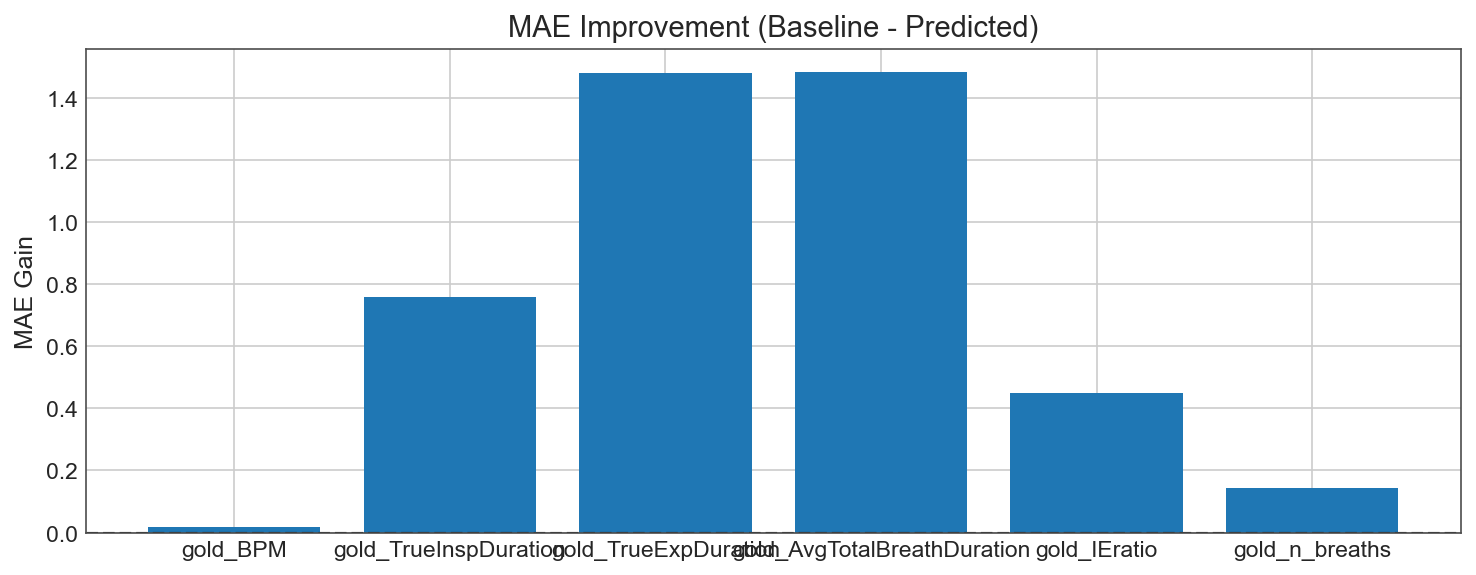

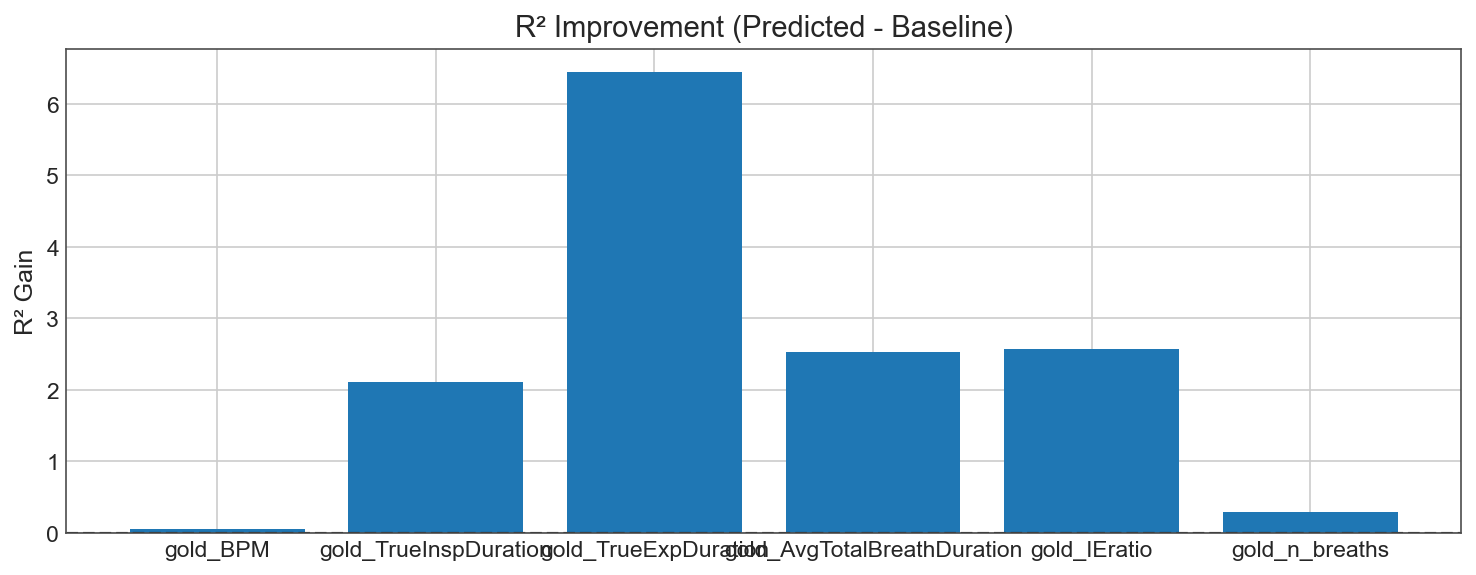


📈 Paired t-test (Baseline MAE vs Predicted MAE):
    t-statistic: 2.759
    p-value:     0.0399
✅ Statistically significant improvement (p < 0.05)


In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import ttest_rel


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.figsize": (10, 4),
    "axes.edgecolor": "0.3",
    "axes.linewidth": 0.8
})


DATAFILES_FOLDER = r"C:\Users\visnu\DIAMONDS\Thesis code\Datafiles"
os.makedirs(DATAFILES_FOLDER, exist_ok=True)


model_path = os.path.join(DATAFILES_FOLDER, "breath_ml_model_10.joblib")
test_path  = os.path.join(DATAFILES_FOLDER, "test_split_10.xlsx")
model = joblib.load(model_path)
df_test = pd.read_excel(test_path)


NUMERIC_COLS = [
    "EDR_BPM", "n_breaths", "AvgTotalBreathDuration",
    "TrueInspDuration", "TrueExpDuration", "IEratio"
]
CATEGORICAL_COLS = []
FULL_FEATURE_COLS = NUMERIC_COLS + CATEGORICAL_COLS
TARGET_COLS = [
    "gold_BPM", "gold_TrueInspDuration", "gold_TrueExpDuration",
    "gold_AvgTotalBreathDuration", "gold_IEratio", "gold_n_breaths"
]

X_test_full = df_test[FULL_FEATURE_COLS]
X_test_num  = df_test[NUMERIC_COLS]
y_test      = df_test[TARGET_COLS]
y_test_np   = y_test.to_numpy()


preds = model.predict(X_test_full)


baseline_mae   = mean_absolute_error(y_test_np, X_test_num, multioutput='raw_values')
predicted_mae  = mean_absolute_error(y_test_np, preds, multioutput='raw_values')
baseline_r2    = r2_score(y_test_np, X_test_num, multioutput='raw_values')
predicted_r2   = r2_score(y_test_np, preds, multioutput='raw_values')

print("📊 MAE per feature (Baseline vs Gold):", np.round(baseline_mae, 3))
print("📊 MAE per feature (Predicted vs Gold):", np.round(predicted_mae, 3))
print(f"\n📉 Mean Baseline MAE:  {baseline_mae.mean():.3f}")
print(f"📈 Mean Predicted MAE: {predicted_mae.mean():.3f}")
print(f"📉 Mean Baseline R²:   {baseline_r2.mean():.3f}")
print(f"📈 Mean Predicted R²:  {predicted_r2.mean():.3f}")

x = np.arange(len(TARGET_COLS))
bar_width = 0.35

plt.figure()
plt.bar(x - bar_width/2, baseline_mae, bar_width, label='Baseline')
plt.bar(x + bar_width/2, predicted_mae, bar_width, label='Predicted')
plt.xticks(x, TARGET_COLS, rotation=45, ha='right')
plt.ylabel('MAE')
plt.title('Baseline vs Predicted MAE per Feature')
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(DATAFILES_FOLDER, "mae_comparison.pdf"))
plt.show()


plt.figure()
plt.bar(x - bar_width/2, baseline_r2, bar_width, label='Baseline')
plt.bar(x + bar_width/2, predicted_r2, bar_width, label='Predicted')
plt.xticks(x, TARGET_COLS, rotation=45, ha='right')
plt.ylabel('R² Score')
plt.title('Baseline vs Predicted R² per Feature')
plt.grid(True, axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(DATAFILES_FOLDER, "r2_comparison.pdf"))
plt.show()


improvement_mae = baseline_mae - predicted_mae
improvement_r2  = predicted_r2 - baseline_r2

plt.figure()
plt.bar(TARGET_COLS, improvement_mae)
plt.axhline(0, color='black', linestyle='--')
plt.title("MAE Improvement (Baseline - Predicted)")
plt.ylabel("MAE Gain")
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(DATAFILES_FOLDER, "mae_gain.pdf"))
plt.show()

plt.figure()
plt.bar(TARGET_COLS, improvement_r2)
plt.axhline(0, color='black', linestyle='--')
plt.title("R² Improvement (Predicted - Baseline)")
plt.ylabel("R² Gain")
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(DATAFILES_FOLDER, "r2_gain.pdf"))
plt.show()


t_stat, p_val = ttest_rel(baseline_mae, predicted_mae)
print(f"\n📈 Paired t-test (Baseline MAE vs Predicted MAE):")
print(f"    t-statistic: {t_stat:.3f}")
print(f"    p-value:     {p_val:.4f}")

if p_val < 0.05:
    print("Statistically significant improvement (p < 0.05)")
else:
    print("❌ No significant improvement (p ≥ 0.05)")


results_df = pd.DataFrame({
    "Feature": TARGET_COLS,
    "MAE_Baseline": baseline_mae,
    "MAE_Predicted": predicted_mae,
    "R2_Baseline": baseline_r2,
    "R2_Predicted": predicted_r2,
    "MAE_Improvement": improvement_mae,
    "R2_Improvement": improvement_r2,
})
results_df.to_excel(os.path.join(DATAFILES_FOLDER, "evaluation_baseline_vs_predicted.xlsx"), index=False)
